# Import data

In [4]:
#import libraries
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [5]:
#import data
df_dig = pd.read_csv('data/Digital_Contact.csv', sep=';')

# Explore Data

In [6]:
df_dig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cust_ID       4000 non-null   int64  
 1   Email_Clicks  4000 non-null   int64  
 2   SM_Comments   4000 non-null   int64  
 3   App_Clicks    4000 non-null   int64  
 4   SM_Likes      4000 non-null   int64  
 5   SM_Shares     3961 non-null   float64
 6   SM_Clicks     4000 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 218.9 KB


- Dtypes seem appropriate
- 4000 entries, only SM_Shares have missing data

Initial Suggestions:  
- turn Cust_ID as index
- explore correlations between features: missing values in SM_Shares may not be relevant if other feature is highly correlated

In [7]:
df_dig.head()

,Cust_ID,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
0,4,72,1,7,7,1.0,73
1,5,15,20,1,35,15.0,16
2,6,9,7,3,73,19.0,10
3,9,67,0,2,0,1.0,101
4,10,38,0,1,9,0.0,56


In [8]:
#Cust_IDs are unique?
len(df_dig['Cust_ID'].unique())

4000

Yes, we can turn index as Cust_ID.

In [9]:
#Cust_ID as index
df_dig.set_index('Cust_ID', inplace=True)
df_dig.head(5)

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,72,1,7,7,1.0,73
5,15,20,1,35,15.0,16
6,9,7,3,73,19.0,10
9,67,0,2,0,1.0,101
10,38,0,1,9,0.0,56


In [10]:
#basic statistics
df_dig.describe()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
count,4000.00000,4000.000000,4000.000000,4000.000000,3961.000000,4000.000000
mean,25.76225,8.247750,19.526500,26.957000,8.355971,30.349250
std,23.65998,8.064963,34.237945,27.742658,8.696192,32.254974
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.00000,1.000000,2.000000,4.000000,1.000000,7.000000
50%,16.00000,4.000000,4.000000,11.000000,2.000000,15.000000
75%,36.00000,15.000000,7.000000,50.000000,16.000000,60.000000
max,86.00000,24.000000,127.000000,88.000000,26.000000,102.000000


All features seem to not be normally distributed, with values of mean around 2x the median - right tail.

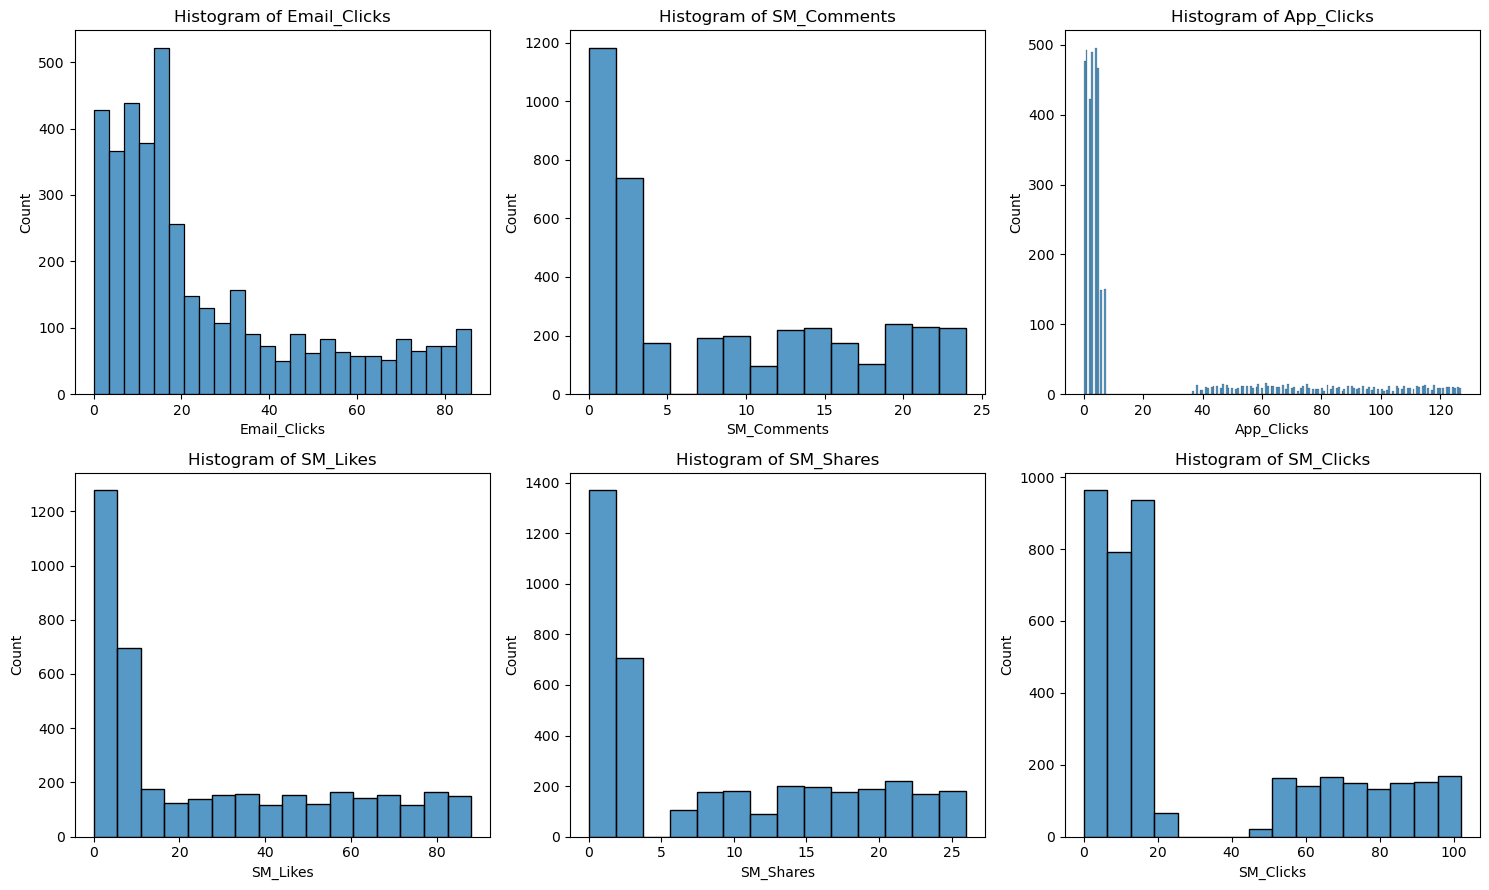

In [11]:
#look ate distribution of values
fig, axes = plt.subplots(2, 3, figsize=(15, 9))  # Create a 2x3 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to iterate over it

for i, column in enumerate(df_dig.columns):
        sns.histplot(df_dig[column], ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

There is mostly an tendency for a group of people to interact very little (the majority) with social apps, and other groups wwll distributed with some to many interactions.  

The resemblance of SM_Comments with SM_Shares is striking. We should investigate this - and all correlations.

No outliers observed.

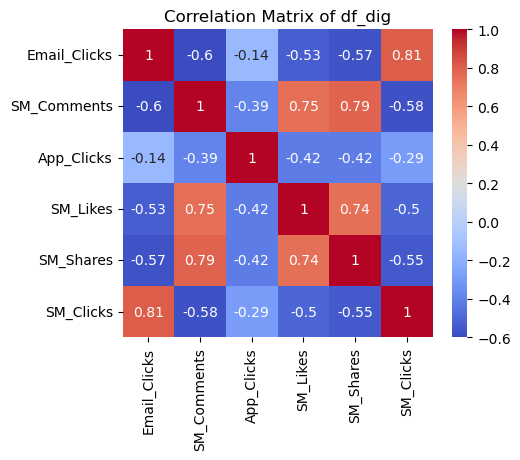

In [12]:
#correlatiomn between features
corr_matrix = df_dig.corr()
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(5, 4))  # Set the size of the figure
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')#, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of df_dig')
plt.show()

There are some high correlations:
- **SM** interactions are highly correlated 0.74-0.79  
  - with a notable **exception**: moderare inverse correlation of **SM_clicks**  

    
- **Email_Clicks** is **inversely** correlated with **all** other features, except a high correlation with **SM_clicks**  

     
- **App_clicks** are generally moderately **inversely** correlated with **all** other features.   

# Regular clustering - kmeans and feature reduction

## Feature Reduction and Feature Scaling
one or two SM features?
(Variance Explained: Consider how much of the variance in your dataset is explained by these features. Sometimes, despite high correlation, both features might capture different aspects that are critical for clustering.)

**Two aproaches to compare for reducing dimensionality:**
1) delete two of the the correlated SM columns and keep one (Shares, Likes, and Comments)
2) put the three together into one new column (after normalization)
   - keeps all the information with less noise
   - more difficult to interpret beyond ('social interaction')


### DF One: two SM columns less
The correlation between SM_Comments and SM_Shares is not high enough so that we can eliminate the SM_Shares feature.
Among Shares, Likes, and Comments, Shares has missing values and should be eliminated.  

Between Comments and Likes, Comments keeps a higher correlation with the eliminated Shares column, thus Comments will be kept as representative of the SM interactions.

In [13]:
#new option 1 df:
df_dig_one=df_dig.drop(['SM_Shares','SM_Likes'], axis=1)
df_dig_one.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Clicks
Cust_ID,,,,
4,72,1,7,73
5,15,20,1,16
6,9,7,3,10
9,67,0,2,101
10,38,0,1,56


In [14]:
#scale features
scaler_one = StandardScaler()
df_dig_one_scaled = pd.DataFrame(scaler_one.fit_transform(df_dig_one), columns = df_dig_one.columns) #applied to all columns because all are numeric
df_dig_one_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Clicks
0,1.954504,-0.898784,-0.365912,1.322465
1,-0.454928,1.457380,-0.541178,-0.444925
2,-0.708553,-0.154732,-0.482756,-0.630966
3,1.743150,-1.022792,-0.511967,2.190657
4,0.517299,-1.022792,-0.541178,0.795349


### DF Two: pull three SM columns into one
SM_shares, SM_likes, and SM_comments

In [15]:
#percentage of SM_Shares null values
df_dig['SM_Shares'].isnull().mean()

0.00975

Less than 1% of values of SM_Shares are missing. Given the apparent existence of at least two populations, neither the mean or the median would be suitable to fill missing values. Other features do not allow a good estimation of the missing values.  
Since the missing values represent such a low proportion of the populations let's eliminate them.

In [16]:
#drop entries with missing values
df_dig_two = df_dig.dropna()
print(len(df_dig_two))

3961


In [17]:
#scale features
scaler_two = StandardScaler()
df_dig_two_scaled = pd.DataFrame(scaler_two.fit_transform(df_dig_two), columns = df_dig_two.columns) #applied to all columns because all are numeric
df_dig_two_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
0,1.949793,-0.899284,-0.364554,-0.719960,-0.845991,1.318321
1,-0.455812,1.456415,-0.539705,0.289296,0.764112,-0.446787
2,-0.709033,-0.155379,-0.481321,1.659002,1.224142,-0.632587
3,1.738775,-1.023269,-0.510513,-0.972275,-0.845991,2.185392
4,0.514871,-1.023269,-0.539705,-0.647871,-0.960998,0.791886


In [18]:
#pull Shares, Likes, and Comments into Interactions
df_dig_two_scaled['SM_interactions'] = df_dig_two_scaled[['SM_Comments', 'SM_Likes', 'SM_Shares']].mean(axis=1)
df_dig_two_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks,SM_interactions
0,1.949793,-0.899284,-0.364554,-0.719960,-0.845991,1.318321,-0.821745
1,-0.455812,1.456415,-0.539705,0.289296,0.764112,-0.446787,0.836608
2,-0.709033,-0.155379,-0.481321,1.659002,1.224142,-0.632587,0.909255
3,1.738775,-1.023269,-0.510513,-0.972275,-0.845991,2.185392,-0.947178
4,0.514871,-1.023269,-0.539705,-0.647871,-0.960998,0.791886,-0.877379


In [19]:
df_dig_two_scaled.drop(['SM_Comments', 'SM_Likes', 'SM_Shares'], axis=1, inplace=True)
df_dig_two_scaled.head()

,Email_Clicks,App_Clicks,SM_Clicks,SM_interactions
0,1.949793,-0.364554,1.318321,-0.821745
1,-0.455812,-0.539705,-0.446787,0.836608
2,-0.709033,-0.481321,-0.632587,0.909255
3,1.738775,-0.510513,2.185392,-0.947178
4,0.514871,-0.539705,0.791886,-0.877379


## Determine Optimal Number of Clusters
Elbow Method, Silhouette Score, or the Gap Statistic

### Option One:

C:\Users\nihon\anaconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\nihon\anaconda3\envs\ds\Lib\subprocess.py", line 1538, in _execute_child


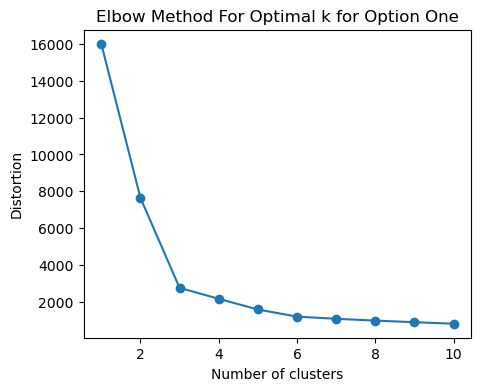

In [20]:
# Calculate distortion for a range of number of cluster
distortions_one = []
for i in range(1, 11):
    km_one = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    km_one.fit(df_dig_one_scaled)
    km_one.fit(df_dig_one_scaled)
    distortions_one.append(km_one.inertia_)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions_one, marker='o')
plt.title('Elbow Method For Optimal k for Option One')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

**3 clusters** seem ideal to characterize our data. (option one)

### Option Two

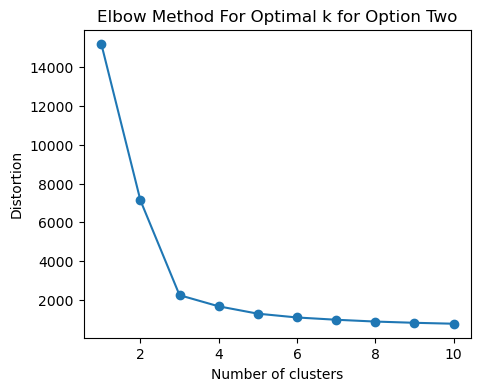

In [21]:
# Calculate distortion for a range of number of cluster
distortions_two = []
for i in range(1, 11):
    km_two = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42) #kmean++ to get a better spreading of the initial centroids
    km_two.fit(df_dig_two_scaled)
    distortions_two.append(km_two.inertia_)

# Plot the elbow graph
plt.figure(figsize=(5, 4))
plt.plot(range(1, 11), distortions_two, marker='o')
plt.title('Elbow Method For Optimal k for Option Two')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

**3 clusters** is also ideal for option Two.

In [22]:
#compare both approaches
print(f'Distortion of 3 clusters for Option One: {distortions_one[2]}')
print(f'Distortion of 3 clusters for Option Two: {distortions_two[2]}')

Distortion of 3 clusters for Option One: 2766.58808772605
Distortion of 3 clusters for Option Two: 2232.088459040278


- **Option Two** clusters seem to represent better the data with lower distances beteween data each cluster: 2232 vs 2762.

## K-Means Clustering

### Option One

In [23]:
#Option One
n_clusters=3
km_one_final = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
km_one_final.fit(df_dig_one_scaled)
df_dig_one_scaled['cluster'] = pd.Series(km_one_final.predict(df_dig_one_scaled))
df_dig_one_scaled.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Clicks,cluster
0,1.954504,-0.898784,-0.365912,1.322465,0
1,-0.454928,1.457380,-0.541178,-0.444925,1
2,-0.708553,-0.154732,-0.482756,-0.630966,1
3,1.743150,-1.022792,-0.511967,2.190657,0
4,0.517299,-1.022792,-0.541178,0.795349,0


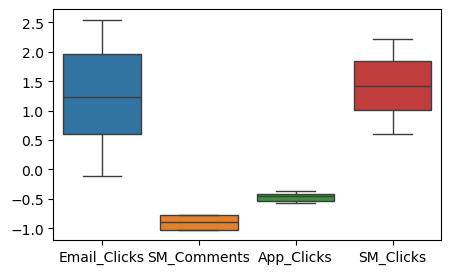

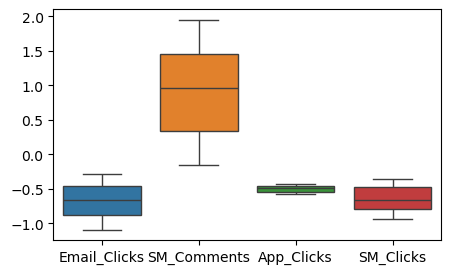

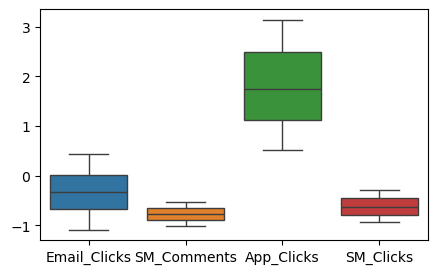

In [24]:
#look at each cluster's data
for i in range(n_clusters):
    plt.figure(figsize=(5, 3))
    sns.boxplot(data=df_dig_one_scaled[df_dig_one_scaled['cluster'] == i].iloc[:,0:-1])
    plt.title('')
    plt.show()

The 3 cluster have 3 well defined behaviors:
1) The 'high commenters', with **SM_Comments** being the only feature above average (and the other two gighly correlated, deleted features)
2) The 'social clickers', with **Email_clicks** and **SM_Clicks** above average.
3) The 'app clickers', with **App_clicks** above average.

### Option Two

In [25]:
#Option One
n_clusters=3
km_two_final = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
km_two_final.fit(df_dig_two_scaled)
df_dig_two_scaled['cluster'] = pd.Series(km_two_final.predict(df_dig_two_scaled))
df_dig_two_scaled.head()

,Email_Clicks,App_Clicks,SM_Clicks,SM_interactions,cluster
0,1.949793,-0.364554,1.318321,-0.821745,1
1,-0.455812,-0.539705,-0.446787,0.836608,0
2,-0.709033,-0.481321,-0.632587,0.909255,0
3,1.738775,-0.510513,2.185392,-0.947178,1
4,0.514871,-0.539705,0.791886,-0.877379,1


Cluster 0


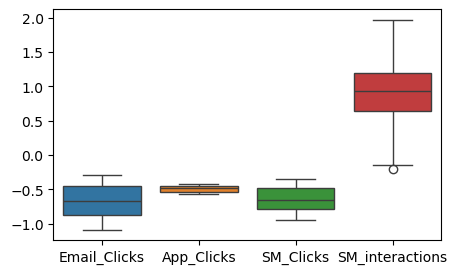

Cluster 1


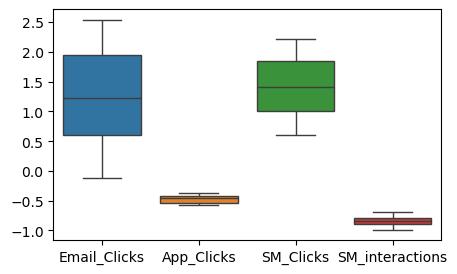

Cluster 2


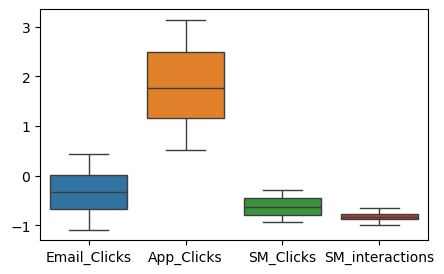

In [26]:
#look at each cluster's data
for i in range(n_clusters):
    print(f'Cluster {i}')
    plt.figure(figsize=(5, 3))
    sns.boxplot(data=df_dig_two_scaled[df_dig_two_scaled['cluster'] == i].iloc[:,0:-1])
    plt.title('')
    plt.show()

The conclusions are very similar to Option One. Copied below:
1) The 'socializers', with **SM_Interactions** being the only feature above average
2) The 'social clickers', with **Email_clicks** and **SM_Clicks** above average.
3) The 'app clickers', with **App_clicks** the only above average.

## Strategies and decisions:
- choose option one or two: depends on the spread of the data that characterizes each group
- make numeric characterization to transform numbers back to the originals

### Interpret Results:
(Interpret the characteristics of each cluster. Understand what each cluster represents in the context of client behavior.)

### Actionable Insights:
(Use the segmentation to derive actionable insights for business strategies such as targeted marketing, personalized customer engagement, etc.)

In [27]:
df_dig.head(15)

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,72,1,7,7,1.0,73
5,15,20,1,35,15.0,16
6,9,7,3,73,19.0,10
9,67,0,2,0,1.0,101
10,38,0,1,9,0.0,56
11,66,1,4,7,1.0,93
12,12,7,3,31,14.0,8
15,60,2,5,1,2.0,57
18,5,12,1,38,26.0,12


# Advanced Clustering - PCA for dimension reduction and other clustering technique

In [28]:
#check original df
df_dig.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,72,1,7,7,1.0,73
5,15,20,1,35,15.0,16
6,9,7,3,73,19.0,10
9,67,0,2,0,1.0,101
10,38,0,1,9,0.0,56


In [37]:
df_dig.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Email_Clicks  4000 non-null   int64  
 1   SM_Comments   4000 non-null   int64  
 2   App_Clicks    4000 non-null   int64  
 3   SM_Likes      4000 non-null   int64  
 4   SM_Shares     3961 non-null   float64
 5   SM_Clicks     4000 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 218.8 KB


In [39]:
#as seen before, delete empty values
df_dig_clean2 = df_dig.dropna()
print(len(df_dig_clean2))
df_dig_clean2.head()

3961


,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,72,1,7,7,1.0,73
5,15,20,1,35,15.0,16
6,9,7,3,73,19.0,10
9,67,0,2,0,1.0,101
10,38,0,1,9,0.0,56


Null entries dropped successfully.

**Strategy**:  
- one way to reduce highly correlated dimensions is to apply **PCA**.
  - "capture a large amount of variance within a potentially much smaller number of dimensions"
  - is more objective than Options One and Two from above
  - dimenssion reduction is objectively quantifiable
- Before applying PCA we need to standardize the data

**Steps**:
- Standardization
- PCA
- run clustering

## Feature scaling (standardization)

In [42]:
#scale data before performing PCA
scaler=StandardScaler()
df_dig_std=pd.DataFrame(scaler.fit_transform(df_dig_clean2), columns=df_dig.columns)
df_dig_std.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
0,1.949793,-0.899284,-0.364554,-0.719960,-0.845991,1.318321
1,-0.455812,1.456415,-0.539705,0.289296,0.764112,-0.446787
2,-0.709033,-0.155379,-0.481321,1.659002,1.224142,-0.632587
3,1.738775,-1.023269,-0.510513,-0.972275,-0.845991,2.185392
4,0.514871,-1.023269,-0.539705,-0.647871,-0.960998,0.791886


## PCA

In [44]:
#explore how much variance wach PC captures
nr_features = df_dig_std.shape[1]
pca = PCA(n_components=nr_features)
df_dig_std_trans= pd.DataFrame(pca.fit_transform(df_dig_std), columns=df_dig_std.columns)
df_dig_std_trans.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
0,-2.426692,-1.217819,0.199753,-0.540605,0.022526,0.103644
1,1.625624,-0.402371,-0.535203,-0.254748,-0.569809,-0.082413
2,1.865391,-0.309268,0.739393,0.305619,1.086704,0.114707
3,-2.835435,-1.586392,-0.074060,-0.074042,0.062251,-0.443649
4,-1.674682,-0.536610,0.021067,0.585181,0.020710,0.371444


In [45]:
#recover index values
df_dig_std_trans.index = df_dig_clean2.index
df_dig_std_trans.head()

,Email_Clicks,SM_Comments,App_Clicks,SM_Likes,SM_Shares,SM_Clicks
Cust_ID,,,,,,
4,-2.426692,-1.217819,0.199753,-0.540605,0.022526,0.103644
5,1.625624,-0.402371,-0.535203,-0.254748,-0.569809,-0.082413
6,1.865391,-0.309268,0.739393,0.305619,1.086704,0.114707
9,-2.835435,-1.586392,-0.074060,-0.074042,0.062251,-0.443649
10,-1.674682,-0.536610,0.021067,0.585181,0.020710,0.371444


In [47]:
# Print the results
print('PCA Summary')
print('No. of features: ', df_dig_std_trans.shape[1])
print('No. of samples: ', df_dig_std_trans.shape[0])
print('No. of components: ', pca.n_components_)
print('Explained variance ratio: ', pca.explained_variance_ratio_)


*************** PCA Summary ***************
No. of features:  6
No. of samples:  3961
No. of components:  6
Explained variance ratio:  [0.60602568 0.25615021 0.044529   0.03778703 0.03455958 0.02094849]


In [51]:
#let's analyze how many components we should keep
#plot cumulative explained variance
cum_variance=[]
for i, value in enumerate(pca.explained_variance_ratio_):
    if i==0:
        cum_variance.append(value)
    else:
        cum_variance.append(value+cum_variance[i-1])
print('Cumulative variance ratio ober PCs: ', cum_variance)

Cumulative variance ratio ober PCs:  [0.6060256844685572, 0.862175898468887, 0.9067048985264893, 0.9444919288558291, 0.9790515114157416, 1.0]


With only **3 dimensions** we get more than **90% of the explained variance**.

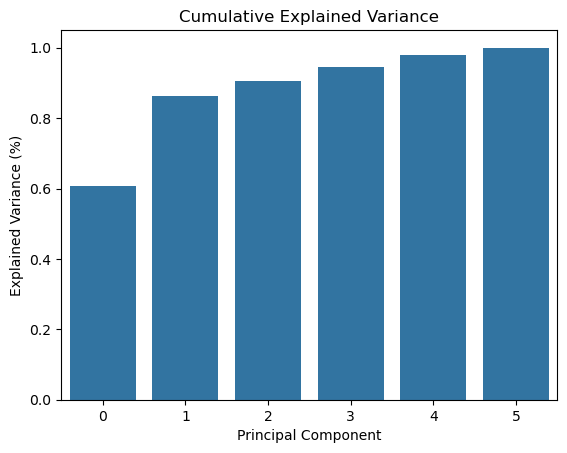

In [70]:
#Graphical representation of PCs' cumulative variance ratio
sns.barplot(data=cum_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.show()

### Final PCA model

In [78]:
#PCA with 3 features
pca_final = PCA(n_components=3)
df_dig_std_trans_final= pd.DataFrame(pca_final.fit_transform(df_dig_std))

df_dig_std_trans_final.index = df_dig_clean2.index
df_dig_std_trans_final.columns += 1
df_dig_std_trans_final.head()

,1,2,3
Cust_ID,,,
4,-2.426692,-1.217819,0.199753
5,1.625624,-0.402371,-0.535203
6,1.865391,-0.309268,0.739393
9,-2.835435,-1.586392,-0.074060
10,-1.674682,-0.536610,0.021067


<Axes: ylabel='Count'>

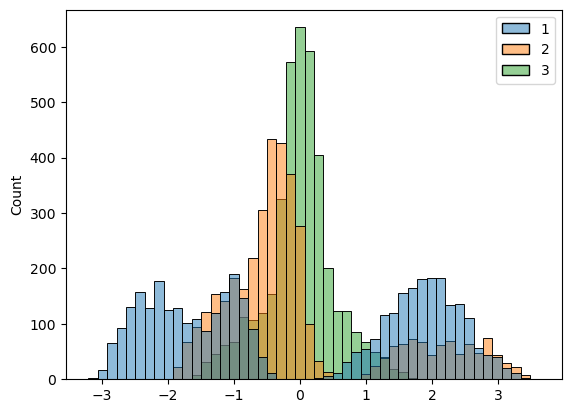

In [79]:
#look at data distribution
sns.histplot(data=df_dig_std_trans_final)

In [77]:
df_dig_std_trans_final.describe()

,0,1,2
count,3.961000e+03,3.961000e+03,3.961000e+03
mean,-2.332001e-17,-1.076308e-17,-1.233270e-17
std,1.907111e+00,1.239875e+00,5.169540e-01
min,-3.200186e+00,-1.956662e+00,-1.627092e+00
25%,-1.808017e+00,-7.461416e-01,-2.278785e-01
50%,-7.135296e-01,-3.298830e-01,1.116292e-02
75%,1.864207e+00,6.679319e-02,2.527435e-01
max,3.605226e+00,3.622148e+00,1.669280e+00


Components 1 and 2 are distributed over two populations - as observed in the original data.  

K-means is not the appropriate clustering algorithm as it is better for data distributed in a globular manner.